In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

[nltk_data] Downloading package stopwords to C:\Users\Dhruv
[nltk_data]     Saxena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
for dirname, _ , filenames in os.walk("../bbc_data/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../bbc_data/README.TXT
../bbc_data/business\001.txt
../bbc_data/business\002.txt
../bbc_data/business\003.txt
../bbc_data/business\004.txt
../bbc_data/business\005.txt
../bbc_data/business\006.txt
../bbc_data/business\007.txt
../bbc_data/business\008.txt
../bbc_data/business\009.txt
../bbc_data/business\010.txt
../bbc_data/business\011.txt
../bbc_data/business\012.txt
../bbc_data/business\013.txt
../bbc_data/business\014.txt
../bbc_data/business\015.txt
../bbc_data/business\016.txt
../bbc_data/business\017.txt
../bbc_data/business\018.txt
../bbc_data/business\019.txt
../bbc_data/business\020.txt
../bbc_data/business\021.txt
../bbc_data/business\022.txt
../bbc_data/business\023.txt
../bbc_data/business\024.txt
../bbc_data/business\025.txt
../bbc_data/business\026.txt
../bbc_data/business\027.txt
../bbc_data/business\028.txt
../bbc_data/business\029.txt
../bbc_data/business\030.txt
../bbc_data/business\031.txt
../bbc_data/business\032.txt
../bbc_data/business\033.txt
../bbc_data/business

In [3]:
directory = []
file = []
title = []
text = []
label = []
datapath = r"../bbc_data/"
for dirname, _, filenames in os.walk(datapath):
    try:
        filenames.remove("README.TXT")
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)


In [4]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df.head()

,text,label
0,"Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet conne...",business
1,The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. And Alan Greenspan highlighted the US government's willingness to curb spending and rising ho...,business
2,The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax clai...,business
3,"British Airways has blamed high fuel prices for a 40% drop in profits. Reporting its results for the three months to 31 December 2004, the airline made a pre-tax profit of £75m ($141m) compared with £125m a year earlier. Rod Eddington, BA's chief e...",business
4,Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is cons...,business


In [5]:
df["label"].value_counts()

label
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [6]:
label_mapping = {"sport": 0, "business": 1, "politics": 2, "tech": 3, "entertainment": 4}
df["label"]=df.label.map(label_mapping)


In [7]:
df["label"].value_counts()

label
0    511
1    510
2    417
3    401
4    386
Name: count, dtype: int64

In [8]:
import re

In [9]:
df.head()

,text,label
0,"Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet conne...",1
1,The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. And Alan Greenspan highlighted the US government's willingness to curb spending and rising ho...,1
2,The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax clai...,1
3,"British Airways has blamed high fuel prices for a 40% drop in profits. Reporting its results for the three months to 31 December 2004, the airline made a pre-tax profit of £75m ($141m) compared with £125m a year earlier. Rod Eddington, BA's chief e...",1
4,Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is cons...,1


In [10]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [11]:
# Let's apply regex and do cleaning. 
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [12]:
df["clean_text"]= df["text"].apply(data_cleaning)

In [13]:
df.head()

,text,label,clean_text
0,"Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet conne...",1,quarterly profits at us media giant timewarner jumped to £ for the three months to december from yearearlier the firm which is now one of the biggest investors in google benefited from sales of highspeed internet connections and higher advert sa...
1,The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. And Alan Greenspan highlighted the US government's willingness to curb spending and rising ho...,1,the dollar has hit its highest level against the euro in almost three months after the federal reserve head said the us trade deficit is set to stabilise and alan greenspan highlighted the us governments willingness to curb spending and rising hous...
2,The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax clai...,1,the owners of embattled russian oil giant yukos are to ask the buyer of its former production unit to pay back a £ loan stateowned rosneft bought the yugansk unit for in a sale forced by russia to part settle a tax claim against yukos yukos owne...
3,"British Airways has blamed high fuel prices for a 40% drop in profits. Reporting its results for the three months to 31 December 2004, the airline made a pre-tax profit of £75m ($141m) compared with £125m a year earlier. Rod Eddington, BA's chief e...",1,british airways has blamed high fuel prices for a drop in profits reporting its results for the three months to december the airline made a pretax profit of £ compared with £ a year earlier rod eddington bas chief executive said the results wer...
4,Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is cons...,1,shares in uk drinks and food firm allied domecq have risen on speculation that it could be the target of a takeover by frances pernod ricard reports in the wall street journal and the financial times suggested that the french spirits firm is consid...


In [14]:
x = df["clean_text"]
y = df["label"]

In [15]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

1668 1668
557 557


In [16]:
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [17]:
max_words = 50000
max_len = 3000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [18]:
es_callback = EarlyStopping(monitor='val_loss', mode='auto',
                            patience=3)

In [19]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 3000, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


In [20]:
# # starting model training
history = model.fit(sequences_matrix,y_train,batch_size=64,epochs = 10,
                   validation_split=0.2,callbacks=[es_callback])

Epoch 1/10
21/21 [==============================] - 223s 10s/step - loss: 1.6371 - accuracy: 0.2684 - val_loss: 1.5410 - val_accuracy: 0.4401
Epoch 2/10
21/21 [==============================] - 220s 10s/step - loss: 1.3417 - accuracy: 0.4273 - val_loss: 1.2347 - val_accuracy: 0.4431
Epoch 3/10
21/21 [==============================] - 220s 10s/step - loss: 1.1200 - accuracy: 0.5742 - val_loss: 1.0859 - val_accuracy: 0.5389
Epoch 4/10
21/21 [==============================] - 222s 11s/step - loss: 0.9307 - accuracy: 0.6544 - val_loss: 0.7453 - val_accuracy: 0.6826
Epoch 5/10
21/21 [==============================] - 221s 11s/step - loss: 0.6350 - accuracy: 0.7601 - val_loss: 1.0372 - val_accuracy: 0.5599
Epoch 6/10
21/21 [==============================] - 221s 11s/step - loss: 0.5790 - accuracy: 0.7946 - val_loss: 0.5210 - val_accuracy: 0.8323
Epoch 7/10
21/21 [==============================] - 221s 11s/step - loss: 0.4755 - accuracy: 0.8546 - val_loss: 0.5589 - val_accuracy: 0.7934
Epoch 

In [21]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [22]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

18/18 [==============================] - 15s 855ms/step - loss: 0.3969 - accuracy: 0.8815


In [23]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.397
  Accuracy: 0.882


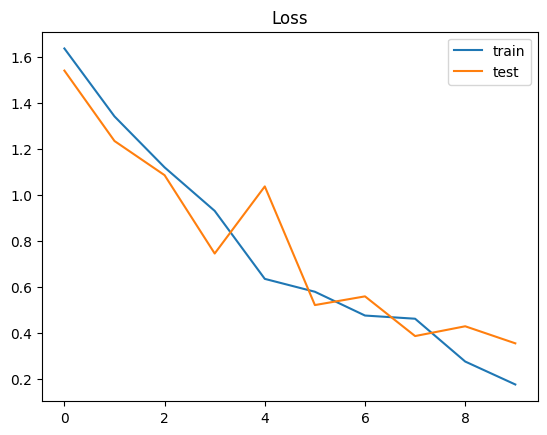

In [29]:

import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

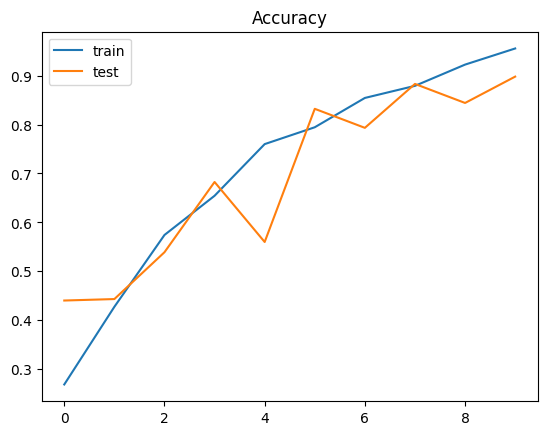

In [30]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [25]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Let's save the mdoel.
model.save("model.pkl")

In [43]:
print(df["clean_text"][50])

  ferrari could be listed on the stock market as part of an overhaul of fiats carmaking operations the financial times has reported  it said fiat was set to restructure its business after reaching a   euros £ settlement with gm about fiats ownership steps being considered include listing ferrari and bringing maserati and alfa romeo closer together it said despite strong sales of alfa romeo fiats car business is making a loss  under the proposals  which the paper said could be announced within days  the iconic sportscar maker could be listed separately on the market fiat owns a  stake in ferrari best known for its dominant formula one motor racing team  having first bought into the business in  it considered floating ferrari in  but opted to sell a minority stake to italian bank mediobanca for  euros  that sale valued ferrari  which owns the maserati brand  at  euros the price tag would change if maserati was stripped out the financial times said fiat may transfer maserati within its wh

In [48]:
df.iloc[50]

text            Ferrari could be listed on the stock market as part of an overhaul of Fiat's carmaking operations, the Financial Times has reported.  It said Fiat was set to restructure its business after reaching a $2bn (1.53bn euros; £1.05bn) settlement with GM a...
label                                                                                                                                                                                                                                                                      1
clean_text      ferrari could be listed on the stock market as part of an overhaul of fiats carmaking operations the financial times has reported  it said fiat was set to restructure its business after reaching a   euros £ settlement with gm about fiats ownership s...
Name: 50, dtype: object

In [39]:
import keras

In [40]:
load_model=keras.models.load_model("model.pkl")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [66]:
test = df["clean_text"][50]
def clean_text(file):
    with open(file, encoding='utf8') as f:
        for text in f:
             text =text.strip()
             print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test=[clean_text("../bbc_data\\business\\001.txt")]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=3000)
print(seq)
pred = load_model.predict(padded)
print(pred)
pred = np.argmax(pred[0])
print(pred)
label_mapping = {0: "Sport", 1: "Business", 2: "politics", 3: "tech", 4: "entertainment"}
print(label_mapping[pred])
# if np.argmax(pred[0]) == 0:
#     print(f"Document Classified as: Sports. With Index of: {np.argmax(pred[0])}")
# elif np.argmax(pred[0]) == 1:
#     print(f"Document Classified as: Business. With Index of: {np.argmax(pred[0])}")
# elif np.argmax(pred[0]) == 2:
#     print(f"Document Classified as: Politics. With Index of: {np.argmax(pred[0])}")
# elif np.argmax(pred[0]) == 3:
#     print(f"Document Classified as: Tech. With Index of: {np.argmax(pred[0])}")
# elif np.argmax(pred[0]) == 4:
#     print(f"Document Classified as: Entertainment. With Index of: {np.argmax(pred[0])}")


Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL